<a href="https://colab.research.google.com/github/arunimamuralitharan/mllab/blob/main/xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(25670, 13)
data shape: (25670, 13)
Old Shape before trimming:  (22145, 13)
New Shape after trimming:  (18800, 13)
                    kms     transmission            2door     displacement  \
count  18800.0000000000 18800.0000000000 18800.0000000000 18800.0000000000   
mean  188569.7500000000     0.2551063895     0.0823936164  1906.7551269531   
std    61656.8085937500     0.4359325767     0.2749707699   577.5012207031   
min      111.0000000000     0.0000000000     0.0000000000   101.0000000000   
25%   158512.7500000000     0.0000000000     0.0000000000  1587.7500000000   
50%   188000.0000000000     0.0000000000     0.0000000000  1900.0000000000   
75%   221000.0000000000     1.0000000000     0.0000000000  2000.0000000000   
max   791100.0000000000     1.0000000000     1.0000000000  6800.0000000000   

                    hp             euro            price  
count 18800.0000000000 15565.0000000000 18800.0000000000  
mean    131.0409088135     4.3478960991 11497.6113281250  
std  

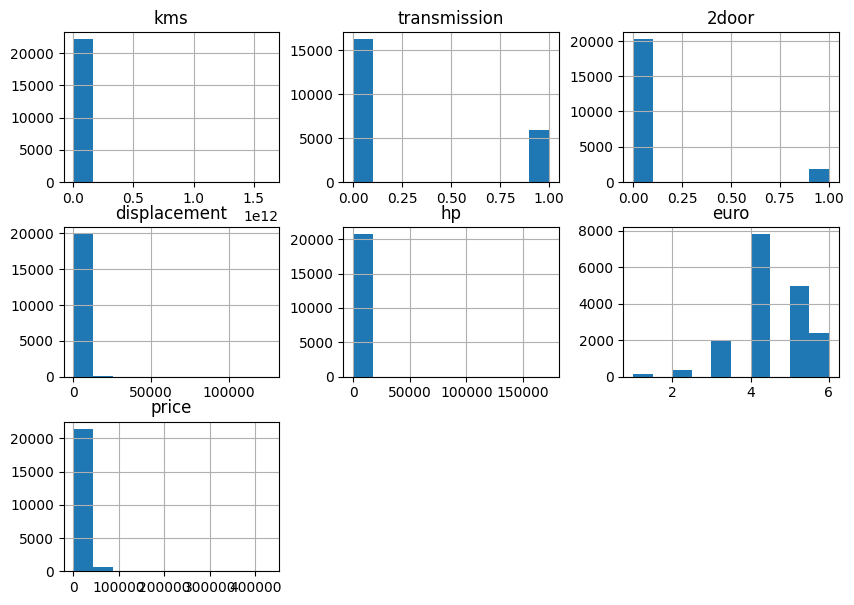

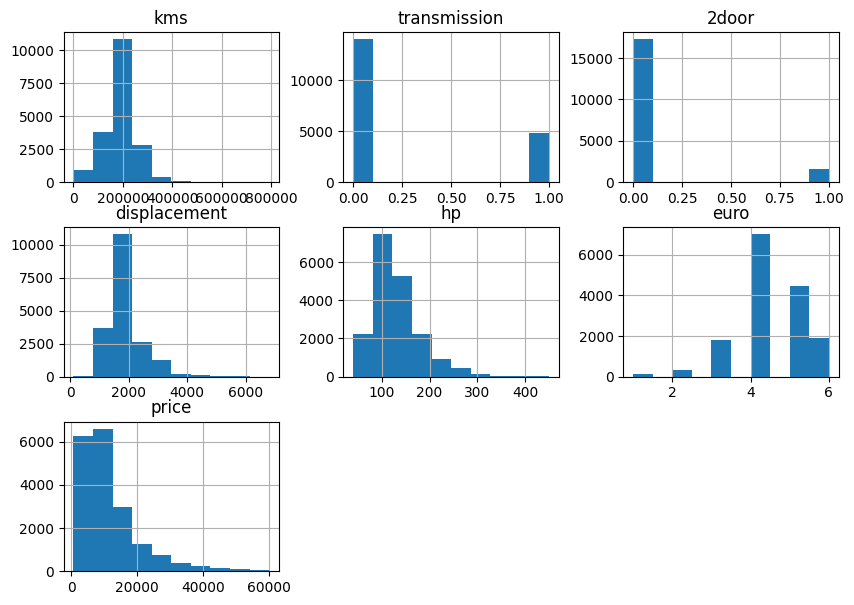

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
plt.rcParams["figure.figsize"] = (10,7)
#Load data
data = pd.read_csv('https://raw.githubusercontent.com/kartheesan05/dataset/main/cars-data3.csv', index_col=None)
# Remove Id column
data = data.drop(['id'],axis='columns')
print(data.shape)
data.head()
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['missing'] = df.isna().sum()


    return summ

summary(data).style.background_gradient(cmap='YlOrBr')
data.loc[data['brand'] == 'BMW', ['brand','model']][:10]
# Remove brands that are seen less than 200 times
data = data.groupby('brand').filter(lambda x :len(x)>200)

#Format BMW model
def format_bmw_model(model_name):
  if 'X' in model_name or 'i' in model_name:
    return model_name
  return model_name[0]

# Trim model to just 1 letter except if it is X or i ex.(318 to 3)
data.loc[data['brand'] == 'BMW', ['model']] = data[data.brand == 'BMW'].model.apply(lambda x: format_bmw_model(x))

# Remove models that are met less than 20 times
data = data.groupby('model').filter(lambda x :len(x)>20)

# Remove cars from years that are met less than 10 times
data = data.groupby('year').filter(lambda x :len(x)>10)
data[["transmission", "2door"]]
# Select columns with 'float64' dtype
float64_cols = list(data.select_dtypes(include='float64'))

data[float64_cols].hist()
print("Old Shape before trimming: ", data.shape)
data = data[(data.hp >30) & (data.hp < 480)]
data = data[(data.price >100) & (data.price < 60000)]
data = data[(data.displacement >100) & (data.displacement < 8000)]
data = data[(data.kms >100) & (data.kms < 1000000)]
print("New Shape after trimming: ", data.shape)

# Turn from float64 to float32 for performance
data[float64_cols] = data[float64_cols].astype('float32')

print(data[float64_cols].describe())

data[float64_cols].hist()
maximum_kms = int(data.kms.max())

def make_buckets(df):
  bins = [0,50000, 100000, 150000,200000,250000,300000,400000,500000,600000,maximum_kms]
  labels = [1,2,3,4,5,6,7,8,9,10]
  df['kms'] = pd.cut(x = df['kms'],
                     bins = bins,
                     labels = labels,
                     include_lowest = True)
  return df

data = make_buckets(data)

# Making it int because pd.cut makes it category type
data["kms"] = data["kms"].astype('int32')

data.dtypes
categorical_cols = list(data.select_dtypes(include='object'))
data[categorical_cols] = data[categorical_cols].astype('category')
data.dtypes
X = data.copy()

# Label
y = X.pop('price')

# Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.20, random_state=42, shuffle = True)

# max_cat_to_onehot is a threshlod value for one-hot encoding features
# if a feature has less than the specified threshold it gets one-hot encoded
# otherwise it is ordinal encoded
model = XGBRegressor(random_state=42,
                     tree_method="hist",
                     eval_metric="mae" ,
                     max_depth=5,
                     enable_categorical=True,
                    max_cat_to_onehot=21,
)

# color, type, fuel will be one-hot encoded
# fit model
model.fit(X_train, y_train,eval_set=[(X_test, y_test)], verbose=False)
mae_train = -1 * cross_val_score(model, X_train, y_train,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')


mae_test = -1 * cross_val_score(model, X_test, y_test,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')

# Supress scientific notation
pd.options.display.float_format = '{:.10f}'.format

print("Mean absolute error CV train: ", mae_train.mean())

print("Mean absolute error CV test: ", mae_test.mean())
fis = zip(X.columns.to_list(),list(model.feature_importances_))
for col, fi in fis:
  print(col," ", fi)

NameError: name 'data' is not defined